<a href="https://colab.research.google.com/github/Samin-Sadaf7/MasteringObjectDetection/blob/main/MasteringObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Object Detection API
The course I am following: https://www.youtube.com/playlist?list=PLLLR8OQ3THK4Ff5Qs8fehzYLN73-VE3BA

Part 1: Data Processing

*   Install the necessary packages
*   Import the packages as well



In [2]:
# for interacting with operating system
import os
import pathlib
from google.colab import drive
#Mounting to Google Drive
drive.mount('/content/gdrive', force_remount=True)
#Set current directory to MyDrive , put the downloaded files there
%cd gdrive/MyDrive/
# Get current working dir
current_dir= os.getcwd()
print("Root dir:", current_dir)

Mounted at /content/gdrive
/content/gdrive/MyDrive
Root dir: /content/gdrive/MyDrive


In [ ]:
#Clone tensorflow github model repository if it does not exist
if 'models' in pathlib.Path.cwd().parts:
  while 'models' in pathlib.Path.cwd().parts:
    od.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models
#install Object Detection API
%cd $current_dir/models/research
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!pip install .

Cloning into 'models'...
remote: Enumerating objects: 4084, done.
remote: Counting objects: 100% (4084/4084), done.
remote: Compressing objects: 100% (3077/3077), done.
remote: Total 4084 (delta 1185), reused 1989 (delta 947), pack-reused 0
Receiving objects: 100% (4084/4084), 44.62 MiB | 17.39 MiB/s, done.
Resolving deltas: 100% (1185/1185), done.
Updating files: 100% (3696/3696), done.
/content/gdrive/MyDrive/models/research
Processing /content/gdrive/MyDrive/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 90.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
%pwd

'/content/gdrive/MyDrive'

In [9]:
#Install opendataset
!pip install opendatasets

In [10]:
import ast # evaluat input and covert to a data structure
import warnings # used to ignore some warnings
import numpy as np
import pandas as pd

import tensorflow as tf

#Data Visualization
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#Handle Kaggle Dataset
import opendatasets as ods

#ignore all warnings
warnings.simplefilter('ignore')
#Draw in ipython env
%matplotlib inline

#Set up EDA

Annotation tools to install :


*   PyPl image (labelimg)
*   Roboflow



In [11]:
#Download dateset from Kaggle
if not os.path.isdir('birdsod'):
  ods.download('https://www.kaggle.com/datasets/ayoubbensakhria/birdsod')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: saminsadaf
Your Kaggle Key: ··········


100%|██████████| 377M/377M [00:09<00:00, 42.9MB/s]


In [12]:
#Download the scripts for image stats, class balance and annotations
#Remove the current version of the file if it exists
!rm getDimensions.py
#Download the latest version from github
!wget https://raw.githubusercontent.com/ayoubbensakhria/ObjectDetectionFRCNN/master/faster_rcnn_resnet101/getDimensions.py

rm: cannot remove 'getDimensions.py': No such file or directory
--2024-04-07 09:04:58--  https://raw.githubusercontent.com/ayoubbensakhria/ObjectDetectionFRCNN/master/faster_rcnn_resnet101/getDimensions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1568 (1.5K) [text/plain]
Saving to: ‘getDimensions.py’

getDimensions.py    100%[===================>]   1.53K  --.-KB/s    in 0.002s  

2024-04-07 09:04:58 (983 KB/s) - ‘getDimensions.py’ saved [1568/1568]



#Visualize Image Dimension

In [19]:
#Get raw output from getDimensions.py
hwp_output = !python getDimensions.py -i $current_dir/birdsod

In [21]:
# Parse the output and convert to list of coordinate tuples
hw_pairs = ast.literal_eval(hwp_output[0])
#Convert to a dataframe
df_hwpairs = pd.DataFrame(hw_pairs,columns=['width','height'])
df_hwpairs.describe().round(2)

,width,height
count,6142.0,6142.0
mean,640.0,640.0
std,0.0,0.0
min,640.0,640.0
25%,640.0,640.0
50%,640.0,640.0
75%,640.0,640.0
max,640.0,640.0


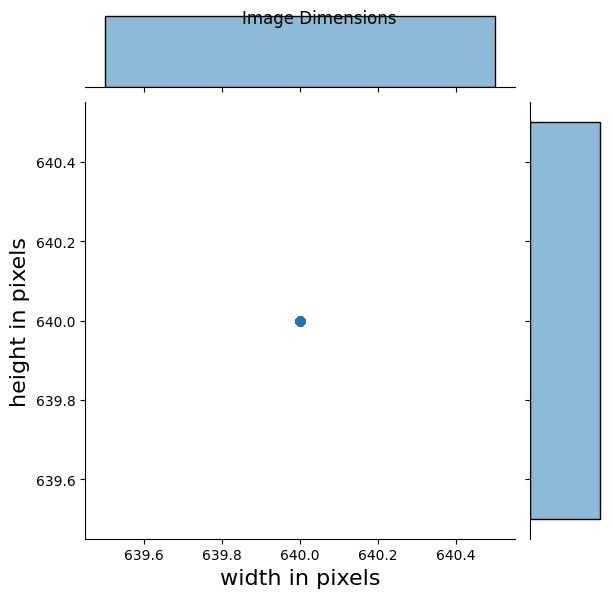

In [23]:
plot = sb.jointplot(data=df_hwpairs, x='width',y='height',kind='reg')
plot.set_axis_labels('width in pixels', 'height in pixels', fontsize = 16)
plot.fig.suptitle('Image Dimensions')
plot

###Class/Annotations Balance

In [24]:
# annotation output is the second element of the array of hwp_output
annotations = ast.literal_eval(hwp_output[1])

#Convert to a df object
df_annotations = pd.DataFrame.from_dict(annotations, orient='index', columns=['Count'])
df_annotations

,Count
Black Kiterotation,381
Brahminy Kiterotation,385
Indian Robinrotation,378
Oriental Magpie Robinrotation,380
Alexandrine Parakeetrotation,362
Asian Koelrotation,392
Indian Paradise-Flycatcherrotation,402
Laughing Doverotation,396
Indian Spot-billed Duckrotation,297
Asian Wooly-necked storkrotation,374


Text(0.5, 0, 'Annotations XML file count')

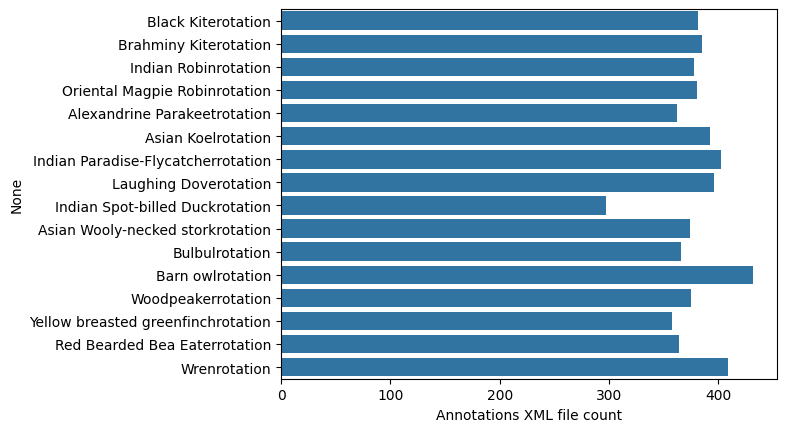

In [25]:
#Plot annotations count
ax = sb.barplot(x='Count',y=df_annotations.index, data = df_annotations)
ax.set_xlabel('Annotations XML file count')